## Read Data

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math
import os 
import seaborn as sns #for styling the plots
import warnings
import urllib.request
from sklearn.mixture import GaussianMixture 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
%matplotlib inline

In [24]:
Complaint_data = pd.read_csv('Complaint_data_cleaned.csv',)
Unemployment_data = pd.read_csv('Unemployment_data_cleaned.csv')
zips = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
Combined_data = pd.read_csv('Combined_data.csv')

In [25]:
Combined_data.head()

,YearMonth,BORO_NM,N_crimes,Labor Force,Employed,Unemployed,Unemployment Rate
0,2013-01,BRONX,1631,600600,522600,78000,13.0
1,2013-01,BROOKLYN,2805,1201200,1077200,123900,10.3
2,2013-01,MANHATTAN,2249,897000,820300,76600,8.5
3,2013-01,QUEENS,1976,1133900,1034500,99400,8.8
4,2013-01,STATEN ISLAND,243,219700,197800,21900,10.0


### Dummy variables representing categorical variables

In [26]:
# Create dummy variables for the 'BORO_NM' column
boro_dummies = pd.get_dummies(Combined_data['BORO_NM'], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
Combined_data_dummies = pd.concat([Combined_data, boro_dummies], axis=1)
Combined_data_dummies.head()


,YearMonth,BORO_NM,N_crimes,Labor Force,Employed,Unemployed,Unemployment Rate,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,2013-01,BRONX,1631,600600,522600,78000,13.0,0,0,0,0
1,2013-01,BROOKLYN,2805,1201200,1077200,123900,10.3,1,0,0,0
2,2013-01,MANHATTAN,2249,897000,820300,76600,8.5,0,1,0,0
3,2013-01,QUEENS,1976,1133900,1034500,99400,8.8,0,0,1,0
4,2013-01,STATEN ISLAND,243,219700,197800,21900,10.0,0,0,0,1


Explanation:
- Dummy variables are a standard and statistically valid way to include categorical variables, such as borough names, as part of the regressors. This allows the model to estimate the impact of each borough, on the dependent variable (N_crimes).

If you have a categorical variable with n levels (the five boroughs of NYC), you would create
n−1 dummy variables. This is because including a dummy variable for every level would introduce multicollinearity, as the sum of all dummy variables would add up to 1, which is perfect multicollinearity (one variable can be perfectly predicted from the others).

By creating n−1 dummy variables, avoid this issue. The level that does not have a dummy variable (the one "left out") serves as the reference category. The coefficients for the dummy variables then represent the effect of each level relative to this reference category.

# Regression Analysis

### Correlation analysis

In [28]:
correlation_matrix = Combined_data_dummies.corr()
correlation_matrix

,N_crimes,Labor Force,Employed,Unemployed,Unemployment Rate,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
N_crimes,1.000000,0.807848,0.798284,0.525745,-0.003033,0.480415,0.323098,0.036129,-0.877221
Labor Force,0.807848,1.000000,0.996297,0.573315,-0.115735,0.531183,0.125527,0.447866,-0.813481
Employed,0.798284,0.996297,1.000000,0.500746,-0.194355,0.519771,0.138725,0.450478,-0.801262
Unemployed,0.525745,0.573315,0.500746,1.000000,0.686925,0.394488,-0.058308,0.216200,-0.554088
Unemployment Rate,-0.003033,-0.115735,-0.194355,0.686925,1.000000,0.014385,-0.183081,-0.096577,-0.055493
BROOKLYN,0.480415,0.531183,0.519771,0.394488,0.014385,1.000000,-0.250000,-0.250000,-0.250000
MANHATTAN,0.323098,0.125527,0.138725,-0.058308,-0.183081,-0.250000,1.000000,-0.250000,-0.250000
QUEENS,0.036129,0.447866,0.450478,0.216200,-0.096577,-0.250000,-0.250000,1.000000,-0.250000
STATEN ISLAND,-0.877221,-0.813481,-0.801262,-0.554088,-0.055493,-0.250000,-0.250000,-0.250000,1.000000


- N_crimes and Labor Force: strong positive correlation (0.807848)
- N_crimes and Employed: strong positive correlation (0.798284) 
- N_crimes and Unemployed: moderate positive correlation (0.525745)
- N_crimes and Unemployment Rate:  weak negative correlation (-0.003033)

## Linear Regression

- uni-variate linear regression on the feature showing the strongest correlation

### Uni-variate linear regression

#### 1.With intercept

In [29]:
# Rename 
Combined_data.rename(columns={'Labor Force':'Labor_Force','Unemployment Rate':'Unemployment_Rate'},inplace = True)

In [30]:
regressors = ['Labor_Force','Employed','Unemployed','Unemployment_Rate']

In [31]:
# Create dataframe
results_df = pd.DataFrame(columns = ['slope','intercept','R2'], index= regressors)

,slope,intercept,R2
Labor_Force,0.001832,204.643529,0.652619
Employed,0.001913,243.647641,0.637258
Unemployed,0.012004,1059.137625,0.276408
Unemployment_Rate,-0.738081,1727.807455,0.000009


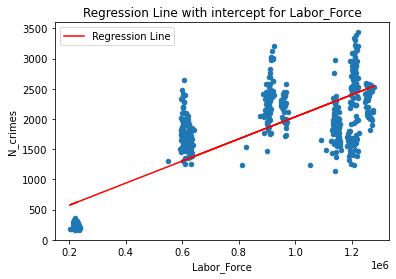

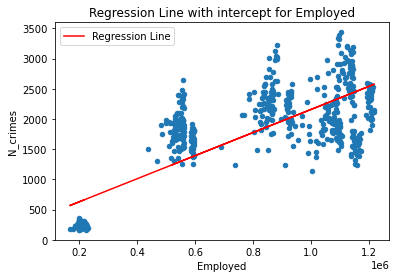

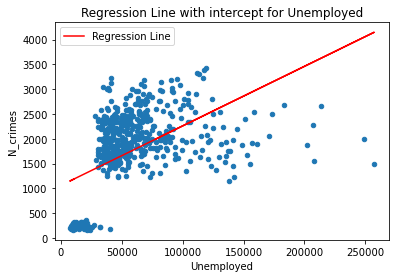

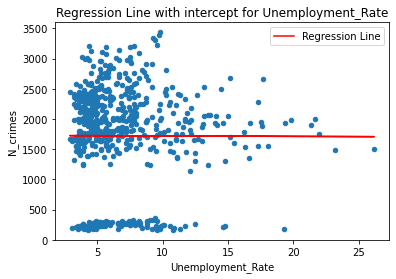

In [32]:
for col in regressors:
    # with intercept
    lm = smf.ols(formula= f'N_crimes~{col}', data = Combined_data).fit()
    
    # storing the results
    results_df.loc[col] = [lm.params[1],lm.params[0],lm.rsquared]
    
    # plot
    fig, ax = plt.subplots() #get axis to plot on
    Combined_data.plot(ax=ax,kind='scatter',x=col, y='N_crimes') #show the data
    ax.plot(Combined_data[col],lm.predict(),'r-',label='Regression Line'); #show the regression line
    plt.title(f'Regression Line with intercept for {col}')
    plt.legend()
results_df

#### 2. Without intercept

In [33]:
# Create dataframe
results_df_without = pd.DataFrame(columns = ['slope','R2'], index= regressors)

,slope,R2
Labor_Force,0.002038,0.931157
Employed,0.002174,0.927339
Unemployed,0.025265,0.766649
Unemployment_Rate,200.22427,0.642442


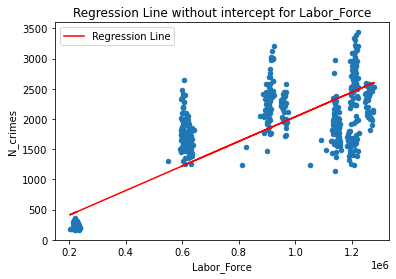

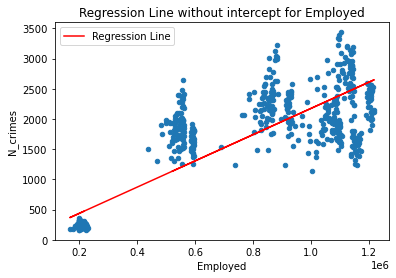

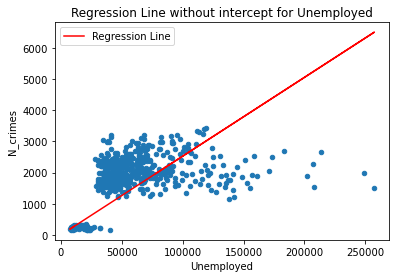

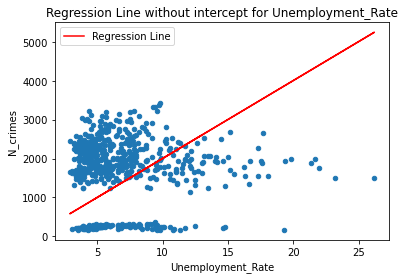

In [34]:
for col in regressors:
    # with intercept
    lm = smf.ols(formula= f'N_crimes~{col}-1', data = Combined_data).fit()
    
    # storing the results
    results_df_without.loc[col] = [lm.params[0],lm.rsquared]
    
    # plot
    fig, ax = plt.subplots() #get axis to plot on
    Combined_data.plot(ax=ax,kind='scatter',x=col, y='N_crimes') #show the data
    ax.plot(Combined_data[col],lm.predict(),'r-',label='Regression Line'); #show the regression line
    plt.title(f'Regression Line without intercept for {col}')
    plt.legend()
results_df_without

In [35]:
results_df, results_df_without

(                      slope    intercept        R2
 Labor_Force        0.001832   204.643529  0.652619
 Employed           0.001913   243.647641  0.637258
 Unemployed         0.012004  1059.137625  0.276408
 Unemployment_Rate -0.738081  1727.807455  0.000009,
                        slope        R2
 Labor_Force         0.002038  0.931157
 Employed            0.002174  0.927339
 Unemployed          0.025265  0.766649
 Unemployment_Rate  200.22427  0.642442)

Interpretations:
- The models without an intercept tend to have higher R-squared values, which suggests better fit to the data. However, the absence of an intercept can lead to misleading interpretations.

- The Unemployed and Unemployment_Rate variables show the most significant change when an intercept is included, indicating that their relationship with N_crime might not be linear or might be affected by other factors not included in the model.

- The negative slope for Unemployment_Rate in the model with an intercept may suggest that higher unemployment rates could be associated with lower crime rates, but the near-zero R-squared indicates that the model is not a good fit, which could mean that the relationship is not linear or that Unemployment_Rate is not a good predictor for N_crime in this context.

- The high slope for Unemployment_Rate without the intercept suggests that without accounting for the baseline crime level (intercept), the model is attributing a large effect to the unemployment rate.

##### With or Without Intercept?
- Intercept-included Model: 
Typically, you would include an intercept in your model unless you have a strong theoretical reason to believe that the relationship between the independent and dependent variables goes through the origin (i.e., when the independent variable is zero, the dependent variable is also expected to be zero). The intercept accounts for the baseline level of the dependent variable when all independent variables are at zero.

- Intercept-excluded Model: 
You would exclude an intercept when you can confidently assert that the absence of the independent variable(s) would result in the absence of the dependent variable. This is less common in observational data, like economic indicators, where the relationship is not necessarily expected to pass through the origin.

Dealing with complex economic data (crime rates, unemployment rates, etc.), it is generally more appropriate to include an intercept. Theoretically, it does not make sense to assert that a 0% unemployment rate would lead to 0 crimes, as crimes can occur for reasons unrelated to employment status.

Moreover, the condition number in both models is quite high, indicating potential multicollinearity. This suggests that the independent variables are highly correlated with each other, which can distort the regression coefficients and their significance levels.

In summary, unless you have a specific theoretical justification for forcing the line through the origin, you should generally include an intercept in your model. Additionally, you should address the multicollinearity in your model, perhaps by excluding some of the highly correlated independent variables or by using regularization techniques.

### Multi-variate regression

In [36]:
lm = smf.ols(formula= 'N_crimes ~ Labor_Force+Employed', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     575.5
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          5.39e-140
Time:                        22:50:22   Log-Likelihood:                -4570.3
No. Observations:                 600   AIC:                             9147.
Df Residuals:                     597   BIC:                             9160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     187.4070     49.544      3.783      

Results:
- R-squared: 0.658 indicates that around 65.8% of the variance in N_crimes is explained by the model.
- Coefficients:
    - Labor_Force: Positive and statistically significant with a coefficient of 0.0038.
    - Employed: Negative and statistically significant with a coefficient of -0.0021.

In [37]:
lm = smf.ols(formula= 'N_crimes ~ Labor_Force+Employed+Unemployed', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     384.3
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          7.43e-139
Time:                        22:50:24   Log-Likelihood:                -4569.6
No. Observations:                 600   AIC:                             9147.
Df Residuals:                     596   BIC:                             9165.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     189.7245     49.570      3.827      

Results:
- R-squared: 0.659, slightly higher than the first model, suggesting a marginal improvement in explanatory power with the addition of Unemployed.
- Coefficients:
    - Labor_Force: Positive coefficient but not statistically significant (p-value > 0.05).
    - Employed: Negative but not statistically significant.
    - Unemployed: Negative but not statistically significant

In [38]:
lm = smf.ols(formula= 'N_crimes~ Labor_Force+Employed+Unemployed+Unemployment_Rate', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     291.4
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          1.35e-138
Time:                        22:50:29   Log-Likelihood:                -4567.1
No. Observations:                 600   AIC:                             9144.
Df Residuals:                     595   BIC:                             9166.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -47.1818    117.34

Results:
- R-squared: 0.662, again slightly higher, indicating that adding Unemployment_Rate provides a slight increase in the model's explanatory power.

- Coefficients:
    - Labor_Force: Positive but not statistically significant.
    - Employed: Negative but not statistically significant.
    - Unemployed: Negative but not statistically significant.
    - Unemployment_Rate: Positive and statistically significant with a coefficient of 34.3490.

In [39]:
lm = smf.ols(formula= 'N_crimes~ Labor_Force + Employed + Unemployed + Unemployment_Rate + C(BORO_NM)', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     610.8
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          5.61e-280
Time:                        22:50:42   Log-Likelihood:                -4224.6
No. Observations:                 600   AIC:                             8467.
Df Residuals:                     591   BIC:                             8507.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Results:

- R-squared: The R-squared value is 0.892, which means that approximately 89.2% of the variance in N_crimes is explained by the model. This is a very high R-squared value, suggesting that the model fits the data well.

- Coefficients for Boroughs: The coefficients for the boroughs are statistically significant (p-value < 0.05), indicating that there are indeed differences in N_crimes across boroughs.

- Coefficients for Other Variables: The Labor_Force, Employed, Unemployed, and Unemployment_Rate are not statistically significant (p-value > 0.05), which suggests that within the context of this model, they do not have a distinct impact on N_crimes after accounting for the effect of boroughs.

- Statistical Significance: The intercept and coefficients for the dummy variables are statistically significant, which means they contribute to explaining the variance in N_crimes.

- Condition Number: The condition number is extremely high, which confirms the presence of multicollinearity. This can inflate the standard errors of the coefficients and make the model unstable.

Interpretation:

- R-squared value: Adding more variables to the model seems to increase the R-squared value slightly, which indicates a better fit of the model to the data. However, the changes are minimal, suggesting that these additional variables do not provide substantially more information about N_crimes.

- The significant change in coefficients and the intercept when moving from a two-variable model to a four-variable model suggests multicollinearity might be affecting the estimates. 

- The lack of statistical significance for Labor_Force, Employed, Unemployed, and Unemployed in the models with more predictors suggests that when combined, these variables do not have a distinct linear relationship with N_crimes.

- The overall fit of the models is reasonable, with R-squared values above 0.65, but the presence of multicollinearity suggests that the independent contributions of the variables cannot be reliably determined. This could be addressed by using regularization methods or variable selection techniques to improve the model.

### Borough-Specific 

In [42]:
results_df2 = pd.DataFrame(columns=['Labor_Force_coef', 
                                    'Employed_coef', 
                                    'Unemployed_coef',
                                    'Unemployment_Rate_coef',
                                    'Intercept', 
                                    'R2'])
results_df2['Borough'] = Combined_data['BORO_NM'].unique()
results_df2 = results_df2.set_index('Borough')

In [43]:
for boro in Combined_data['BORO_NM'].unique():
    
    df_boro = Combined_data[Combined_data['BORO_NM'] == boro]
    lm = smf.ols(formula='N_crimes~ Labor_Force + Employed + Unemployed + Unemployment_Rate', data=df_boro).fit()

    results_df2.loc[boro] = [lm.params['Labor_Force'],
                                   lm.params['Employed'],
                                   lm.params['Unemployed'],
                                   lm.params['Unemployment_Rate'],         
                                   lm.params['Intercept'],
                                   lm.rsquared]
results_df2

,Labor_Force_coef,Employed_coef,Unemployed_coef,Unemployment_Rate_coef,Intercept,R2
Borough,,,,,,
BRONX,-0.34592,0.326027,0.487409,-991.024708,14018.900761,0.190842
BROOKLYN,-1.31934,1.306772,1.44345,-1660.902587,17924.827724,0.290408
MANHATTAN,0.104811,-0.110194,-0.026241,-789.925368,7360.530051,0.130726
QUEENS,0.276266,-0.286367,-0.198684,-1023.199004,13597.130543,0.326744
STATEN ISLAND,-0.004738,-0.001931,0.054706,-129.919254,1768.43472,0.305757


##### Consideration:

1. Single Model with Dummy Variables: Analyzing each borough separately, as shown in your table, allows for a more detailed and specific understanding of the factors influencing N_crimes within each borough. This approach can highlight unique borough-specific relationships that might be obscured when all data are pooled together. For instance, the labor force may have different effects on crime rates in different boroughs

- Provides a more straightforward comparison across boroughs.
- More efficient in terms of degrees of freedom if there is limited data.
- Assumes a consistent relationship between predictors and N_crimes across all boroughs, which might not be accurate.

2. Borough-Specific Models: Using dummy variables in a single regression model for all boroughs gives a more general overview and allows for direct comparison of the boroughs' coefficients relative to a reference category. This method assumes that the relationship between the predictors and N_crimes is consistent across boroughs, except for a shift indicated by the borough's coefficient.

- Allow for different relationships between predictors and N_crimes in each borough.
- Can identify unique borough-level factors affecting crime.
- May be more suitable if the focus is on policy-making or interventions tailored to individual boroughs.
- Require more data to ensure robust estimates for each borough-specific model.

--> Describe the general trends across NYC with the dummy variable model and then delve into the specifics with the borough-specific models.

## Linear Regression Diagnostics

In [44]:
lm = smf.ols(formula= 'N_crimes~ Labor_Force + Employed + Unemployed + Unemployment_Rate + C(BORO_NM)', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     610.8
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          5.61e-280
Time:                        22:54:31   Log-Likelihood:                -4224.6
No. Observations:                 600   AIC:                             8467.
Df Residuals:                     591   BIC:                             8507.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

At the confidence level of 95%, Only the boroughs regressors seem significant according to p-value.
The confidence intervals are pretty broad not allowing to reliably assess the number of crimes for each category of borough. 

- The coefficient for the unemployment rate is negative, but it is not statistically significant since its p-value is greater than 0.05. This implies that there is no strong evidence to suggest the unemployment rate, as modeled, has a significant impact on the number of crimes when controlling for other factors.

- The borough dummy variables are statistically significant, with p-values less than 0.05, indicating that the number of crimes is significantly different across boroughs.

- The negative coefficient for STATEN_ISLAND suggests that, all else being equal, this borough would see fewer crimes compared to the baseline borough (not shown in the output).

- The model suggests multicollinearity may be an issue, as indicated by the note about a singular matrix, which could be due to the high correlation between the predictors such as 'Labor_Force' and 'Employed'.

This is likely because of the strong internal correlations between the regressors.
- refer to the correlation matrix table below

In [45]:
Combined_data.corr()

,N_crimes,Labor_Force,Employed,Unemployed,Unemployment_Rate
N_crimes,1.000000,0.807848,0.798284,0.525745,-0.003033
Labor_Force,0.807848,1.000000,0.996297,0.573315,-0.115735
Employed,0.798284,0.996297,1.000000,0.500746,-0.194355
Unemployed,0.525745,0.573315,0.500746,1.000000,0.686925
Unemployment_Rate,-0.003033,-0.115735,-0.194355,0.686925,1.000000


Interpretation:

- There is a high correlation between 'Labor_Force', 'Employed', and 'Unemployed', which is expected as these are directly related labor market indicators.

- The unemployment rate does not show a strong correlation with the number of crimes, which is consistent with the regression results.


Interpreting the Diagnostics:

- Multicollinearity: Given the high correlation between 'Labor_Force', 'Employed', and 'Unemployed', there is likely multicollinearity in the model. This issue can inflate the variance of the coefficient estimates and make the model less reliable. It may be beneficial to consider variable selection

- Model Fit: The concentration of points along the lower range of observed crimes and the scattering at higher ranges suggest that the model may not be capturing some aspects of the relationship at higher crime levels. This could be due to outliers, non-linear relationships, or other factors not included in the model.

- Borough Differences: The significance of borough dummy variables suggests that location is an important factor in crime rates. This could be due to a variety of socio-economic factors that differ by borough.

- Unemployment Rate: The lack of significance of the unemployment rate might suggest that unemployment alone is not a good predictor of crime rates, or that the relationship is more complex than the model captures. It could also be that the effect of unemployment on crime is mediated through other variables not included in the model.

## Deal with Multicollinearity -- Regularization

Model choosing: General trends across NYC with the dummy variable model

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import statsmodels.formula.api as smf
from scipy.stats import t
from sklearn.metrics import r2_score
matplotlib.rcParams['figure.figsize'] = [10,4]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [47]:
lm = smf.ols(formula= 'N_crimes~ Labor_Force + Employed + Unemployed + Unemployment_Rate + C(BORO_NM)', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     610.8
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          5.61e-280
Time:                        22:58:01   Log-Likelihood:                -4224.6
No. Observations:                 600   AIC:                             8467.
Df Residuals:                     591   BIC:                             8507.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### Split Train (70%), Valid (15%) and Test (15%) data

In [48]:
Train_data, Remaining_data = train_test_split(Combined_data.iloc[:, 1:], test_size=0.3, random_state=30)
Valid_data, Test_data = train_test_split(Remaining_data, test_size=0.5, random_state=30)

In [52]:
Train_data.shape

(420, 6)

In [55]:
Train_data.head()

,BORO_NM,N_crimes,Labor_Force,Employed,Unemployed,Unemployment_Rate
208,QUEENS,1761,1146600,1094700,51900,4.5
181,BROOKLYN,2356,1202500,1134900,67600,5.6
447,MANHATTAN,2058,876600,761000,115500,13.2
362,MANHATTAN,1956,960800,920100,40700,4.2
129,STATEN ISLAND,179,220900,206300,14600,6.6


In [53]:
Valid_data.shape

(90, 6)

In [54]:
Test_data.shape

(90, 6)

In [56]:
'+'.join(Train_data.columns[2:])

'Labor_Force+Employed+Unemployed+Unemployment_Rate'

In [60]:
#first fit the regression over the training data and report the results
lm = smf.ols(formula = 'N_crimes ~ C(BORO_NM) + '+ '+'.join(Train_data.columns[2:]), data = Train_data).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     423.9
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          3.00e-193
Time:                        23:02:08   Log-Likelihood:                -2965.4
No. Observations:                 420   AIC:                             5949.
Df Residuals:                     411   BIC:                             5985.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [61]:
from sklearn.metrics import r2_score
r2_score(Test_data.N_crimes,lm.predict(Test_data))

0.8913834653235929

In [62]:
lm.params

Intercept                      3895.696256
C(BORO_NM)[T.BROOKLYN]         2770.931172
C(BORO_NM)[T.MANHATTAN]        1477.873705
C(BORO_NM)[T.QUEENS]           1811.201039
C(BORO_NM)[T.STATEN ISLAND]   -2887.780253
Labor_Force                      -0.359297
Employed                          0.356035
Unemployed                        0.354314
Unemployment_Rate                -1.160918
dtype: float64

### Regularization methods

In [71]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #alphas: a list of alpha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]


In [72]:
# Create dummy variables for the 'BORO_NM' column
boro_dummies_train = pd.get_dummies(Train_data['BORO_NM'], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
Train_data_dummies = pd.concat([Train_data, boro_dummies_train], axis=1)
Train_data_dummies.head()

,BORO_NM,N_crimes,Labor_Force,Employed,Unemployed,Unemployment_Rate,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
208,QUEENS,1761,1146600,1094700,51900,4.5,0,0,1,0
181,BROOKLYN,2356,1202500,1134900,67600,5.6,1,0,0,0
447,MANHATTAN,2058,876600,761000,115500,13.2,0,1,0,0
362,MANHATTAN,1956,960800,920100,40700,4.2,0,1,0,0
129,STATEN ISLAND,179,220900,206300,14600,6.6,0,0,0,1


In [73]:
# Create dummy variables for the 'BORO_NM' column
boro_dummies_valid = pd.get_dummies(Valid_data['BORO_NM'], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
Valid_data_dummies = pd.concat([Valid_data, boro_dummies_valid], axis=1)
Valid_data_dummies.head()

,BORO_NM,N_crimes,Labor_Force,Employed,Unemployed,Unemployment_Rate,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
595,BRONX,2176,604100,562400,41700,6.9,0,0,0,0
260,BRONX,1656,628900,592300,36600,5.8,0,0,0,0
156,BROOKLYN,3071,1208300,1139700,68600,5.7,1,0,0,0
395,BRONX,1848,624900,589300,35500,5.7,0,0,0,0
563,QUEENS,2098,1135300,1078400,57000,5.0,0,0,1,0


In [74]:
# Create dummy variables for the 'BORO_NM' column
boro_dummies_test = pd.get_dummies(Test_data['BORO_NM'], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
Test_data_dummies = pd.concat([Test_data, boro_dummies_test], axis=1)
Test_data_dummies.iloc[:,2:].head()

,Labor_Force,Employed,Unemployed,Unemployment_Rate,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
87,908800,854100,54700,6.0,0,1,0,0
386,1252300,1202200,50100,4.0,1,0,0,0
80,600000,543300,56700,9.4,0,0,0,0
542,916500,860200,56300,6.1,0,1,0,0
565,599300,555400,44000,7.3,0,0,0,0


In [75]:
alphas = np.exp(np.linspace(-10,10,200))
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,
                                                              Train_data_dummies.iloc[:,2:],Train_data_dummies.N_crimes,
                                                              Valid_data_dummies.iloc[:,2:],Valid_data_dummies.N_crimes,
                                                              alphas,Graph=False,logl=True)
print('Optimal alpha for Lasso={0}, best Validation R_2={1}'.format(alpha_optimal,best_R2))

Optimal alpha for Lasso=4.5399929762484854e-05, best Validation R_2=0.8924918170828328


In [76]:
# Perfromance over the test set
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)
Lasso.fit(Train_data_dummies.iloc[:,2:],Train_data_dummies.N_crimes)

yPred_OS=Lasso.predict(Test_data_dummies.iloc[:,2:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(Test_data_dummies.N_crimes,yPred_OS)))
Lasso.coef_

The OS R-squared of Lasso is: 0.8919627340806562


array([-2.95950616e-03,  2.08241258e-05, -1.44183932e-03, -2.04815225e+00,
        2.56100422e+03,  1.37436005e+03,  1.62768623e+03, -2.75195278e+03])

Interpretation:

- Optimal Alpha: 
Optimal alpha value using Lasso regression that maximizes the validation R-squared, which is around 0.8926. This suggests that the Lasso model with this alpha value is able to explain a large portion of the variability in the crime numbers on the validation set.

- Test Performance: 
The R-squared value on the test set is approximately 0.8919, which is very close to the R-squared on the validation set. This indicates good generalization of the Lasso model to unseen data.

- Coefficients: 
The Lasso regression has resulted in some coefficients being shrunk towards zero, which means those variables contribute less to the model's predictions. 

The output suggests that variables like 'Labor_Force' have coefficients close to zero, indicating a smaller or negligible effect on the number of crimes after regularization.

##### Decide whether to use the Lasso model or the original OLS model:

1. R-squared and Adjusted R-squared: 
Both the Lasso and the original OLS models have similar R-squared values, which are quite high. This means both models explain a significant portion of the variance in the number of crimes. However, the R-squared alone does not account for model complexity.


2. Multicollinearity: 
The note in the OLS output indicates potential multicollinearity ("the smallest eigenvalue is close to 0"). This is a problem Lasso helps to address by shrinking some coefficients towards zero, thereby potentially removing collinear predictors.

3. Coefficient Significance:
In the OLS model, some predictors are not statistically significant (e.g., Labor_Force, Unemployed, and Unemployment_Rate have high p-values), meaning they might not contribute meaningful information to the model. Lasso has likely removed or reduced the impact of these variables.

4. Model Validation: You should validate both models on a hold-out test set or use cross-validation to assess their performance. The model that performs better on unseen data is usually preferred.

5. Interpretability: If interpretability is important for your study, the OLS model provides direct insight into the effect size of each predictor, assuming there's no multicollinearity. However, if Lasso has selected variables, it provides a model that might be more robust to multicollinearity but possibly harder to interpret due to the shrinkage of coefficients.

Given these points,  based on the provided results, the Lasso model appears to be the better choice. It deals effectively with multicollinearity, maintains a high R-squared value, and likely provides a more parsimonious model compared to the original OLS model.

### Lasso model 

- Dropping the regressors with coefficients that are very small (near zero) as indicated by the Lasso model

- Labor_Force: -2.95950616e-03 (very close to zero)
- Employed: 2.08241258e-05 (very close to zero)
- Unemployed: -1.44183932e-03 (very close to zero)
- Unemployment_Rate: -2.04815225e+00
- BROOKLYN: 2.56100422e+03
- MANHATTAN: 1.37436005e+03
- QUEENS: 1.62768623e+03
- STATEN_ISLAND: -2.75195278e+03

Decision: 
Drop: 'Labor_Force', 'Employed', and 'Unemployed' have coefficients very close to zero, suggesting that they have little to no influence on the prediction of crime numbers after the Lasso regularization process.

In [77]:
lm = smf.ols(formula= 'N_crimes ~ Unemployment_Rate + C(BORO_NM)', data = Combined_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               N_crimes   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     923.3
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          2.60e-277
Time:                        23:17:23   Log-Likelihood:                -4241.1
No. Observations:                 600   AIC:                             8494.
Df Residuals:                     594   BIC:                             8521.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Original OLS Model
- R-squared: 0.892
- Adjusted R-squared: 0.891
- Condition Number: 7.34e+07, Indicates potential multicollinearity (smallest eigenvalue is 1.6e-29).

Post-Lasso OLS Model
- R-squared: 0.886
- Adjusted R-squared: 0.885
- Condition Number: 47.1, Better condition number, indicating reduced multicollinearity.

Interpretation:
- The R-squared values are very similar between the two models, indicating that both models explain a high proportion of the variance in 'N_crimes'. The slight decrease in R-squared for the Post-Lasso model is not substantial, suggesting that the removal of 'Labor_Force', 'Employed', and 'Unemployed' did not significantly reduce the model's explanatory power.

- The Adjusted R-squared also decreased slightly in the Post-Lasso model, but this is expected when variables are removed from a model. The fact that it remains high suggests the model is still robust.

- The condition number is improved in the Post-Lasso model. A lower condition number indicates less multicollinearity, suggesting that the Post-Lasso model is more stable and the coefficient estimates are more reliable.


Conclusion:
- The Post-Lasso model is preferred because it is simpler (fewer variables), has dealt with multicollinearity, and has maintained a high level of explanatory power (as indicated by the R-squared values).

- This model should be more generalizable to new data because it is based on fewer predictors, and Lasso regularization helps to prevent overfitting.

- The coefficients in the Post-Lasso model are likely to be more reliable, as they are less affected by multicollinearity, making the model more interpretable.

In summary, the Post-Lasso OLS model is a better choice for further analysis and forecasting due to its stability, reliability, and simplicity, without sacrificing much explanatory power.